# Credit Card Customers for Profiling

Revolving credit is a useful indicator for risk, and credit cards are a revolving credit product that is popular. The number of months that customers have held a credit card is a useful metric to understand how long the customer has had any credit history. Obviously, using this alone has flaws and this dataset might ignore other credit products that the customer may have or had in the past, but my intention is to create cohorts of customers based on a temporal feature. Since there is no 'start date' for the customers in the dataset, I will use the number of months of credit card history to determine a start date.  

To simulate an environment where new customers are entering the portfolio and need predictions, I decided that those with less than 1 year (12 months) of credit history should be separated from the train and test sets.  This assumes that everyone in this 'monitoring set' and wants the home credit product is also new to credit, which would not be the case in real life (some new customers may have years of credit history).  

We will pretend as though the months of credit history in the dataset is just the months of history that we are able to see, and not the number of months the customer has had credit.

+ Split the credit card users into 3 cohorts
    + Those with credit card history for 2 or more years (train)
    + Those with credit card history for 1 - 2 years (test)
    + Those with credit card history for < 1 year (monitoring)
+ Measure the target in each of the cohorts
    + display a table with the 3 cohorts, their counts of SK_ID_CURR, and their count of target = 1
+ Profile each of the cohorts
    + Show how many had 0 balances the whole time
    + Show average balance per month
    + Show utilization over all history
    + Show utilization in the past 12 months, 6 months of their history


In [1]:
import pandas as pd
import os

In [6]:
cc = pd.read_csv("home-credit-default-risk/credit_card_balance.csv")

In [7]:
cc.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [32]:
# get the ID where the minimum months balance is less than 24

min_months = cc.groupby(['SK_ID_CURR'])['MONTHS_BALANCE'].min().reset_index()

train_id_set = min_months[min_months['MONTHS_BALANCE'] <= -24]['SK_ID_CURR']
test_id_set = min_months[(min_months['MONTHS_BALANCE'] > -24) & (min_months['MONTHS_BALANCE'] < -12)]['SK_ID_CURR']
monitoring_id_set = min_months[min_months['MONTHS_BALANCE'] >= -12]['SK_ID_CURR']

# Target

In [33]:
df_train = pd.read_csv('home-credit-default-risk/application_train.csv')
df_test = pd.read_csv('home-credit-default-risk/application_test.csv')

In [57]:
# get and display the count of target in each cohor
vc = df_train[df_train.SK_ID_CURR.isin(train_id_set)].TARGET.value_counts()
train_1, train_0 = vc[1], vc[0]
train_cohort_rate = train_1/train_0


vc = df_train[df_train.SK_ID_CURR.isin(test_id_set)].TARGET.value_counts()
test_1, test_0 = vc[1], vc[0]
test_cohort_rate = (test_1/test_0)

# get and display the count of target in each cohor
vc = df_train[df_train.SK_ID_CURR.isin(monitoring_id_set)].TARGET.value_counts()
monitoring_1, monitoring_0 = vc[1], vc[0]
monitoring_cohort_rate = (monitoring_1/monitoring_0)



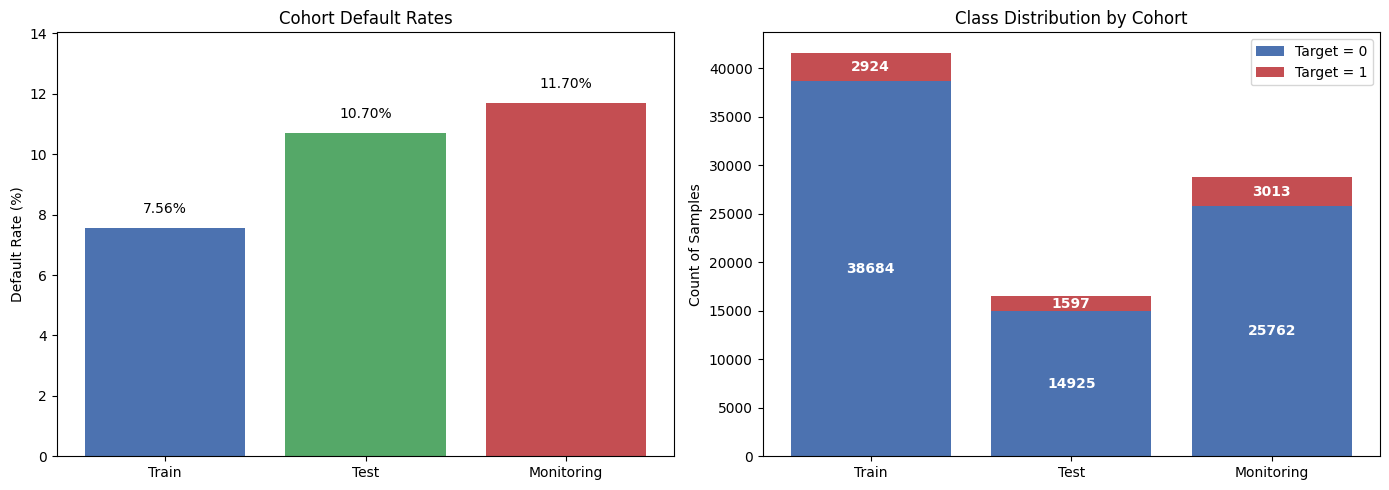

In [111]:
import matplotlib.pyplot as plt

# --- Prepare data ---
# Default rate chart
rates = {
    "Train": train_cohort_rate,
    "Test": test_cohort_rate,
    "Monitoring": monitoring_cohort_rate
}
percentages = {k: v * 100 for k, v in rates.items()}

# Stacked bar chart
cohorts = ["Train", "Test", "Monitoring"]
target_0 = [train_0, test_0, monitoring_0]
target_1 = [train_1, test_1, monitoring_1]

# --- Create subplots ---
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# --- Chart 1: Default rates ---
axes[0].bar(percentages.keys(), percentages.values(), color=["#4c72b0", "#55a868", "#c44e52"])
axes[0].set_ylabel("Default Rate (%)")
axes[0].set_title("Cohort Default Rates")
axes[0].set_ylim(0, max(percentages.values()) * 1.2)

# Add labels on bars
for i, (label, val) in enumerate(percentages.items()):
    axes[0].text(i, val + 0.5, f"{val:.2f}%", ha="center", fontsize=10)

# --- Chart 2: Stacked counts ---
bars0 = axes[1].bar(cohorts, target_0, label="Target = 0", color="#4c72b0")
bars1 = axes[1].bar(cohorts, target_1, bottom=target_0, label="Target = 1", color="#c44e52")

# Add counts for Target=0
for bar, val in zip(bars0, target_0):
    axes[1].text(bar.get_x() + bar.get_width()/2, val/2, str(val),
                 ha="center", va="center", color="white", fontsize=10, fontweight="bold")

# Add counts for Target=1
for bar, base, val in zip(bars1, target_0, target_1):
    axes[1].text(bar.get_x() + bar.get_width()/2, base + val/2, str(val),
                 ha="center", va="center", color="white", fontsize=10, fontweight="bold")

axes[1].set_ylabel("Count of Samples")
axes[1].set_title("Class Distribution by Cohort")
axes[1].legend()

plt.tight_layout()
plt.show()


# Profile

In [ ]:
+ Profile each of the cohorts
    + Show how many had 0 balances the whole time
    + Show average balance per month
    + Show utilization over all history
    + Show utilization in the past 12 months, 6 months of their history


In [79]:
# create a dictionary for saving descriptive stats

stats_dict = {}

# get the average balances for each customer in the train set
avg_balances = cc[cc.SK_ID_CURR.isin(train_id_set)].groupby('SK_ID_CURR')['AMT_BALANCE'].mean()
no_balance_count = (avg_balances==0).sum()
total_count = avg_balances.count()
no_balance_rate = no_balance_count/total_count

stats_dict.update({"train_count": total_count, 
"no_balance_train": no_balance_count,
"no_balance_rate_train": no_balance_rate})

# get the average balances for each customer in the test set
avg_balances = cc[cc.SK_ID_CURR.isin(test_id_set)].groupby('SK_ID_CURR')['AMT_BALANCE'].mean()
no_balance_count = (avg_balances==0).sum()
total_count = avg_balances.count()
no_balance_rate = no_balance_count/total_count

stats_dict.update({"test_count": total_count, 
"no_balance_test": no_balance_count,
"no_balance_rate_test": no_balance_rate})

# get the average balances for each customer in the monitoring set
avg_balances = cc[cc.SK_ID_CURR.isin(monitoring_id_set)].groupby('SK_ID_CURR')['AMT_BALANCE'].mean()
no_balance_count = (avg_balances==0).sum()
total_count = avg_balances.count()
no_balance_rate = no_balance_count/total_count

stats_dict.update({"monitoring_count": total_count, 
"no_balance_monitoring": no_balance_count,
"no_balance_rate_monitoring": no_balance_rate})

In [84]:
stats_dict

{'train_count': np.int64(49749),
 'no_balance_train': np.int64(9787),
 'no_balance_rate_train': np.float64(0.19672757241351585),
 'test_count': np.int64(21269),
 'no_balance_test': np.int64(8042),
 'no_balance_rate_test': np.float64(0.378108984907612),
 'monitoring_count': np.int64(32540),
 'no_balance_monitoring': np.int64(15496),
 'no_balance_rate_monitoring': np.float64(0.4762138905961893)}

In [85]:
df_stats = pd.DataFrame([stats_dict])
df_stats

,train_count,no_balance_train,no_balance_rate_train,test_count,no_balance_test,no_balance_rate_test,monitoring_count,no_balance_monitoring,no_balance_rate_monitoring
0,49749,9787,0.196728,21269,8042,0.378109,32540,15496,0.476214


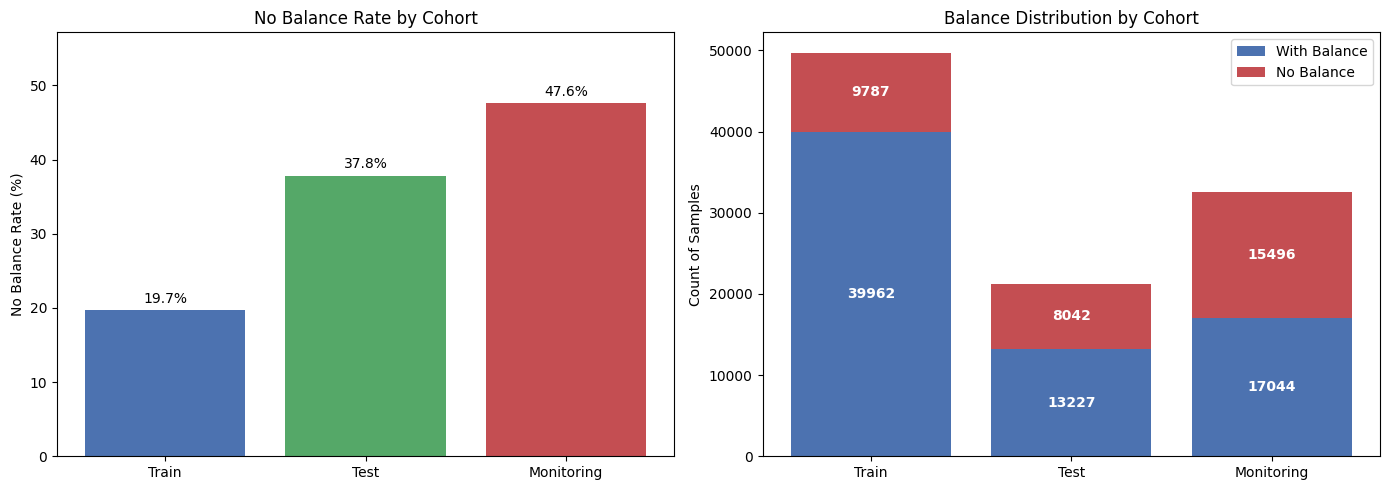

In [112]:
import matplotlib.pyplot as plt

# --- Prepare data ---
# No Balance Rate chart
rates = [
    df_stats["no_balance_rate_train"].iloc[0],
    df_stats["no_balance_rate_test"].iloc[0],
    df_stats["no_balance_rate_monitoring"].iloc[0]
]
labels = ["Train", "Test", "Monitoring"]
percentages = [r*100 for r in rates]

# Stacked With/No Balance chart
total = [
    df_stats["train_count"].iloc[0],
    df_stats["test_count"].iloc[0],
    df_stats["monitoring_count"].iloc[0]
]
no_balance = [
    df_stats["no_balance_train"].iloc[0],
    df_stats["no_balance_test"].iloc[0],
    df_stats["no_balance_monitoring"].iloc[0]
]
with_balance = [t - nb for t, nb in zip(total, no_balance)]

# --- Create subplots ---
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# --- Chart 1: No Balance Rate ---
axes[0].bar(labels, percentages, color=["#4c72b0", "#55a868", "#c44e52"])
axes[0].set_ylabel("No Balance Rate (%)")
axes[0].set_title("No Balance Rate by Cohort")
axes[0].set_ylim(0, max(percentages)*1.2)

# Add percentages on bars
for i, val in enumerate(percentages):
    axes[0].text(i, val + 1, f"{val:.1f}%", ha="center", fontsize=10)

# --- Chart 2: Stacked With/No Balance ---
bars0 = axes[1].bar(labels, with_balance, label="With Balance", color="#4c72b0")
bars1 = axes[1].bar(labels, no_balance, bottom=with_balance, label="No Balance", color="#c44e52")

# Add counts on bars
for i, (wb, nb) in enumerate(zip(with_balance, no_balance)):
    axes[1].text(i, wb/2, str(wb), ha="center", va="center", color="white", fontsize=10, fontweight="bold")
    axes[1].text(i, wb + nb/2, str(nb), ha="center", va="center", color="white", fontsize=10, fontweight="bold")

axes[1].set_ylabel("Count of Samples")
axes[1].set_title("Balance Distribution by Cohort")
axes[1].legend()

plt.tight_layout()
plt.show()


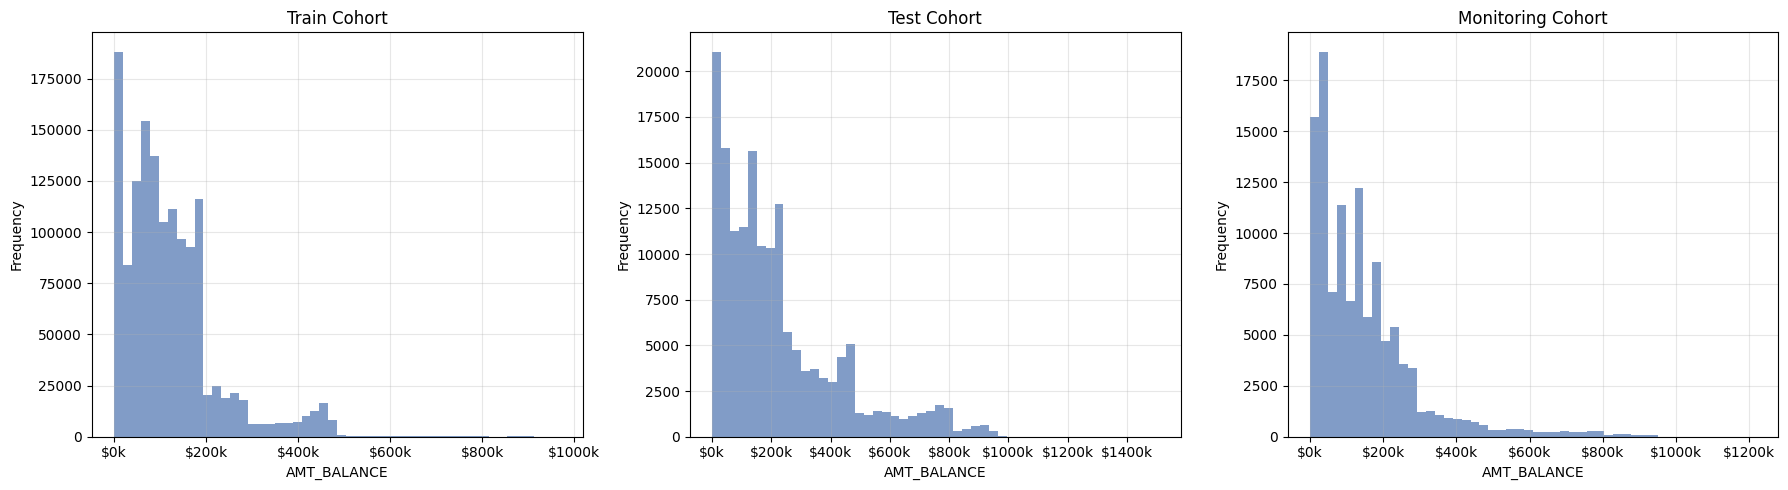

In [110]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

cohorts = {
    "Train": train_id_set,
    "Test": test_id_set,
    "Monitoring": monitoring_id_set
}

plt.figure(figsize=(18,5))  # 3 plots side by side

for i, (label, id_set) in enumerate(cohorts.items(), 1):
    plt.subplot(1, 3, i)
    
    data = cc[(cc.SK_ID_CURR.isin(id_set)) & (cc["AMT_BALANCE"] > 0)]["AMT_BALANCE"]
    
    plt.hist(data, bins=50, alpha=0.7, color="#4c72b0")
    plt.title(f"{label} Cohort")
    plt.xlabel("AMT_BALANCE")
    plt.ylabel("Frequency")
    
    # Format x-axis as $ in thousands
    formatter = FuncFormatter(lambda x, pos: f"${int(x/1000)}k")
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


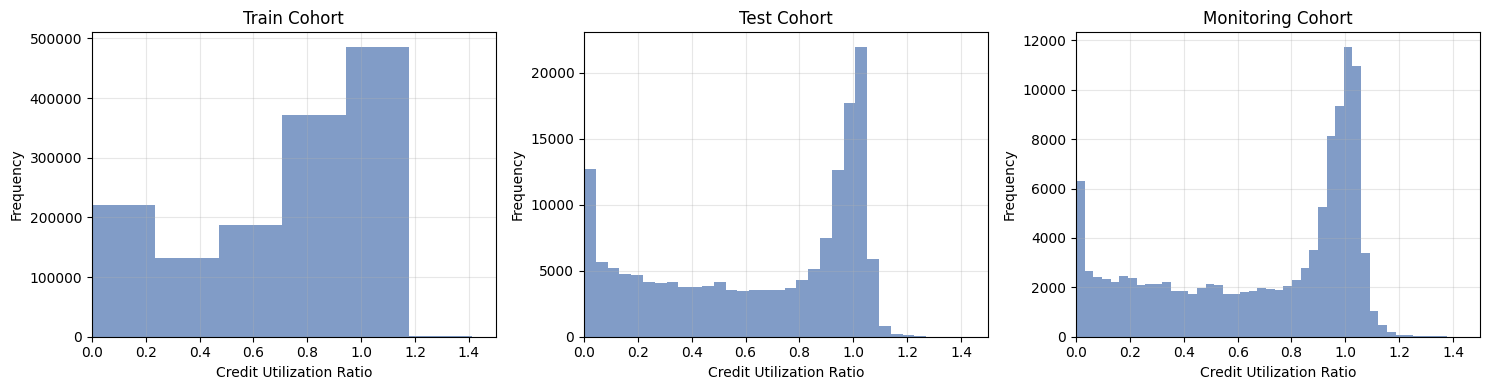

In [109]:
import matplotlib.pyplot as plt

# Prepare cohorts
cohorts = {
    "Train": train_id_set,
    "Test": test_id_set,
    "Monitoring": monitoring_id_set
}

plt.figure(figsize=(15,4))  # 3 plots side by side

for i, (label, id_set) in enumerate(cohorts.items(), 1):
    util = cc[
        (cc.SK_ID_CURR.isin(id_set)) &
        (cc["AMT_BALANCE"] > 0) &
        (cc["AMT_CREDIT_LIMIT_ACTUAL"] > 0)
    ]["AMT_BALANCE"] / cc[
        (cc.SK_ID_CURR.isin(id_set)) &
        (cc["AMT_BALANCE"] > 0) &
        (cc["AMT_CREDIT_LIMIT_ACTUAL"] > 0)
    ]["AMT_CREDIT_LIMIT_ACTUAL"]
    
    plt.subplot(1, 3, i)
    plt.hist(util, bins=50, alpha=0.7, color="#4c72b0")
    plt.title(f"{label} Cohort")
    plt.xlabel("Credit Utilization Ratio")
    plt.ylabel("Frequency")
    plt.xlim(0, 1.5)  # optional: limit x-axis to 150% utilization
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
